## Access Vessel Satellite Radiance data in Zarr
A jupyter notebook to show how to access and plot the AODN vessel_satellite_radiance_delayed_qc dataset available as [Zarr](https://zarr.dev/) dataset on S3.

More information about the dataset available [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/28f8bfed-ca6a-472a-84e4-42563ce4df3f).

In [1]:
dataset_name = "vessel_satellite_radiance_delayed_qc"

In [2]:
# only run once, then restart session if needed
!pip install uv

import os
import sys
import platform

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():  # For Google Colab
    import xarray as xr
    xr.set_options(display_style='text')
    os.system(f'uv pip install --system -r {requirements_path}')
    os.system('uv pip install --system pyopenssl --upgrade')
elif 'jupyter' in platform.uname().node:  # For Nectar Instance https://jupyterhub.rc.nectar.org.au
    os.system(f'uv pip install --system -r {requirements_path}')
else: # If running locallly
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 240 packages in 31ms


In [3]:
import requests
if not os.path.exists('DataQuery.py'):
  print('Downloading DataQuery.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/DataQuery.py'
  response = requests.get(url)
  with open('DataQuery.py', 'w') as f:
      f.write(response.text)

In [4]:
from DataQuery import GetAodn

# Understanding the Dataset

In [5]:
# remote zarr dataset
aodn = GetAodn()
dname = f'{dataset_name}.zarr'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 639 ms, sys: 139 ms, total: 779 ms
Wall time: 2.64 s


In [6]:
ds = aodn_dataset.zarr_store
ds.info()

xarray.Dataset {
dimensions:
	WAVELENGTH_Ed = 200 ;
	TIME = 1637069 ;
	WAVELENGTH_Lsky = 200 ;
	WAVELENGTH_Lu = 200 ;

variables:
	float64 Ed(WAVELENGTH_Ed, TIME) ;
		Ed:ancillary_variables = LATITUDE LONGITUDE relaz sza pitch pitchsd roll rollsd gearpos Ed_quality_control ;
		Ed:cell_method = LATITUDE: LONGITUDE: TIME: point ;
		Ed:long_name = Surface Downwelling Irradiance in air ;
		Ed:standard_name = surface_downwelling_spectral_radiative_flux_in_air ;
		Ed:units = W m^-2 nm^-1 ;
		Ed:valid_max = 10.0 ;
		Ed:valid_min = 0.0 ;
	int32 Ed_quality_control(WAVELENGTH_Ed, TIME) ;
		Ed_quality_control:flag_meanings = No_QC_was_performed Good_data Probably_good_data Bad_data_that_are_potentially_correctable Bad_data Value_changed Not_used Not_used Not_used Missing_value ;
		Ed_quality_control:flag_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ;
		Ed_quality_control:long_name = Surface Downwelling Irradiance Quality Control ;
		Ed_quality_control:quality_control_conventions = IMOS standard flags 

## Plot time coverage

In [7]:
aodn_dataset.get_temporal_extent()

(Timestamp('2011-07-29 05:53:01.080043008'),
 Timestamp('2013-02-18 23:59:59.435729920'))

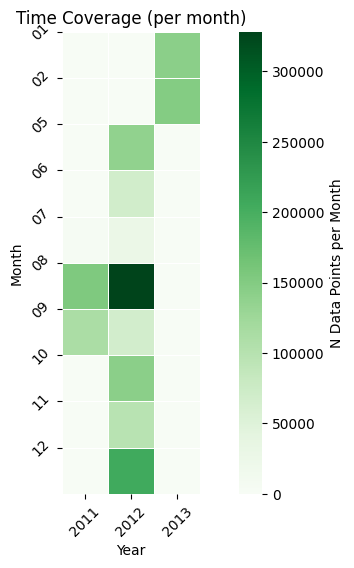

In [8]:
aodn_dataset.plot_time_coverage()

## Read Metadata

In [9]:
meta = aodn_dataset.get_metadata()

2025-05-27 17:21:11,711 - aodn.GetAodn - INFO - Retrieving metadata for s3://aodn-cloud-optimised/vessel_satellite_radiance_delayed_qc.zarr


## List unique vessels and filter data accordingly

In [10]:
import numpy as np
np.unique(ds.platform_code.data)

array(['', 'VLHJ   '], dtype='<U7')

In [11]:
%%time
ds = aodn_dataset.get_data(date_start='2012-06-09', date_end='2012-06-10', scalar_filter = {'platform_code' : 'VLHJ'})

CPU times: user 1.19 s, sys: 163 ms, total: 1.35 s
Wall time: 8.4 s


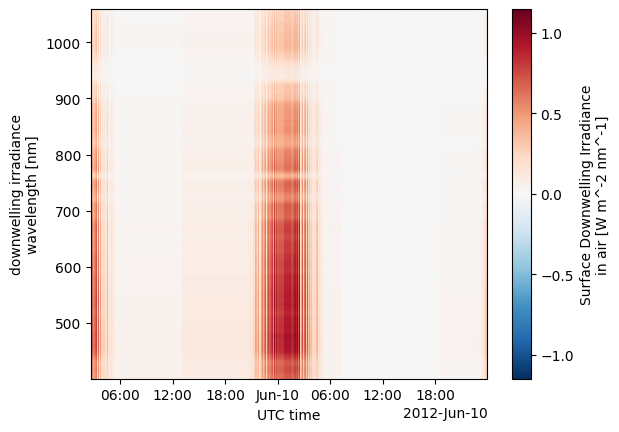

In [12]:
ds.Ed.plot()

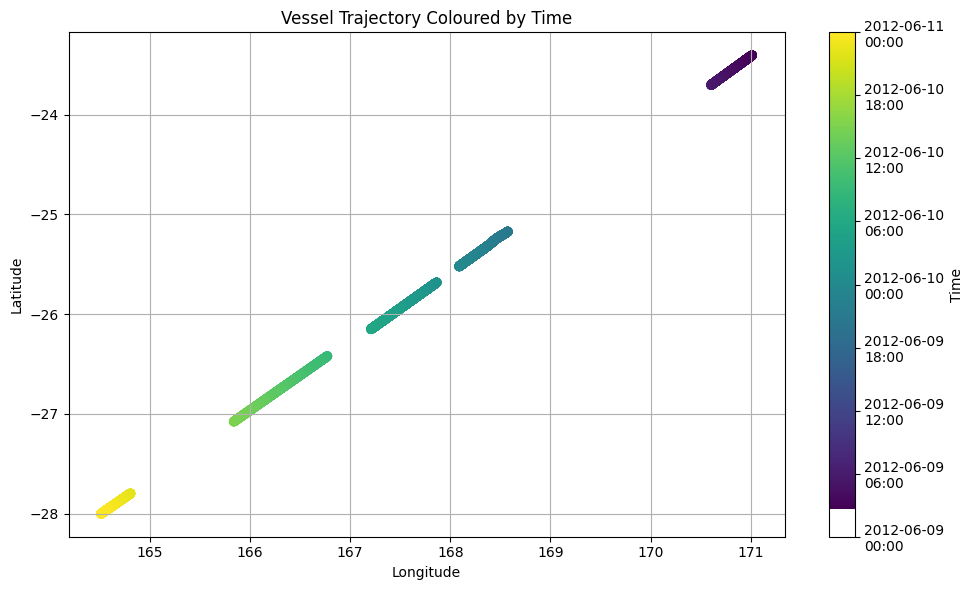

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

time = pd.to_datetime(ds["TIME"].values)
lat = ds["LATITUDE"].values
lon = ds["LONGITUDE"].values

# Convert times to matplotlib's numeric format
times_numeric = mdates.date2num(time)

fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(lon, lat, c=times_numeric, cmap='viridis', marker='o')

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Time')

tick_locs = cbar.get_ticks()
tick_labels = [mdates.num2date(t).strftime('%Y-%m-%d\n%H:%M') for t in tick_locs]
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(tick_labels)

ax.set_title("Vessel Trajectory Coloured by Time")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
plt.tight_layout()
plt.show()
